## Considerações Iniciais

Treinar modelos que envolvam técnicas de Deep Learning e detecção de imagens geralmente necessitam de uma grande quantia de dados para realizar predições precisas e construir modelos robustos.

É importante também frisarmos que, para os requisitos propostos queremos realizar a tarefa de **Detecção de Objetos**, que difere da tarefa de **Classificação de Imagens** uma vez que essa segunda não se preocupa em encontrar o objeto na imagem (por meio de *bounding box* por exemplo), mas sim informar que imagem é de determinada classe.

Um algoritmo bastante utilizado para tarefas de detecção de objeto em imagens é o algoritmo YOLO, este utiliza da lógica de encadeamento de CNNs (Redes Neurais Convolucionais) para realizar tarefas de visão computacional. Além disso o YOLO é um modelo já treinado em uma enorme base de imagens, fazendo com que ele generalize muito bem a tarefa de detecção.

Foram pesquisados também outros algoritmos como MobileNet, ResNet, etc. Porém estes apresentam resultados e arquiteturas mais simples que exercem bem em tarefas de classificação, em que o YOLO apresenta um patamar de estado-da-arte quando o assunto é detecção.

Com as informações ditas acima, para o objetivo do projeto podemos utilizar o modelo YOLO e reaproveitar seus pesos, realizando um processo de Fine-tuning, ou seja iremos ajustá-lo ao nosso dataset de imagens de fumaça repassado. A utilização do YOLO é bem simples e amigável com o pacote `ultralytics`, e a sua versão mais nova é a versão 11, que será utilizada para este projeto.



In [ ]:
# !pip install ultralytics
# !pip install opencv-python

Os próximos passos são necessários para carregar todos os scripts para o google colab

In [1]:
!git clone https://github.com/renneruan/desafio-data-science-2025.git

Cloning into 'desafio-data-science-2025'...
remote: Enumerating objects: 3277, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 3277 (delta 10), reused 44 (delta 6), pack-reused 3228 (from 1)
Receiving objects: 100% (3277/3277), 133.29 MiB | 20.24 MiB/s, done.
Resolving deltas: 100% (21/21), done.
Updating files: 100% (4642/4642), done.


In [3]:
%cd desafio-data-science-2025/

/content/desafio-data-science-2025


Descomentar em troca de ambiente, instala as dependências necessárias

In [6]:
# !pip install -r requirements.txt

In [1]:
import os
import shutil
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
from ultralytics import YOLO
from smoke_detection.utils.commons import get_latest_folder

## Coleta das Imagens



Com a utilização do YOLO em mente, precisamos de um dataset que possua imagens e suas correspondências de fumaça/fogo em bounding box, iniciei a busca de imagens que possam se aproximar das desejadas na biblioteca de imagens https://universe.roboflow.com/.

O objetivo na coleção era encontrar um dataset de imagens possivelmente tiradas por câmeras em torres, como não temos essa informação fácil, escolhemos um dataset que:
- A fumaça/fogo não estivesse tão próximo da câmera;
- Pudessemos traçar uma linha do horizonte definida;
- Sem imagens de drone, satélite ou demais vistas aéreas.
- Neste primeiro momento evitei também datasets com muitas imagens direcionadas para a chama.

Foi utilizada as palavras chaves: *wildfire smoke detection forest fire*.

Um dataset que atendeu as especificações foi o:
https://universe.roboflow.com/tristandeeplearnnig/wildfire-smoke-detection-v7bqc

É possível realizar o download do dataset utilizando o snippet de código abaixo, porém para garantir a disponibilização e evitar a necessidade de cadastro para recuperar a API key, ele também foi baixado em zip e salvo no repositório Git (apenas para caráter de projeto, dados de produção podem ser sensíveis e não devem ser salvos em Git).

In [ ]:
# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="_")
# project = rf.workspace("tristandeeplearnnig").project("wildfire-smoke-detection-v7bqc")
# version = project.version(1)
# dataset = version.download("yolov11")


Observações: Por utilizar um dataset baixado de terceiro, a não ser que verifiquemos imagem por imagem não podemos garantir a qualidade da rotulação e criação dos bounding boxes, além de garantir a total falta de Data Leakege por exemplo. A biblioteca YOLO não apresenta funções nativas para verificar em grande escala essa designação. Na próxima seção irei verificar o perfil do bounding box de uma pequena amostra das imagens baixadas.

Temos como quantia:
- Treino: 1.378
- Validação: 147
- Teste: 74

Proporções aproximadas: 85% 10% 5%

O dataset apresenta apenas uma classe: Smoke

## Verificar o perfil das imagens

Irei realizar uma verificação manual do perfil da rotulagem e das imagens, para isso irei gerar as imagens com as informações de Bounding Box em uma pasta a parte, onde podemos visualizar se as Bounding Box criadas estão correspondentes a área de fumaça.

Para manter este notebook enxuto, criei as funções auxiliares para ler o arquivo YAML de caminho dos dados e criar as imagens com as bounding box nos arquivos `src/smoke_detection/utils/commons.py` e `src/smoke_detection/utils/image_evaluation.py` respectivamente.

In [ ]:
from smoke_detection.utils.commons import read_yaml
from smoke_detection.utils.image_evaluation import iterate_images_and_labels

# Define os caminhos que serão utilizados
all_datasets_path = "../datasets/"
dataset_name = "data/"
processed_dataset_name = "processed_data/"
dataset_path = os.path.join(all_datasets_path, dataset_name)
processed_dataset_path = os.path.join(all_datasets_path, processed_dataset_name)


data_file_path = os.path.join(dataset_path, "data.yaml")
processed_data_file_path = os.path.join(processed_dataset_path, "data.yaml")

# Caminho para as imagens de avaliação manual
path_file = read_yaml(data_file_path)

[2025-02-24 07:16:58,085: INFO: commons: Arquivo yaml: ../datasets/data/data.yaml carregado com sucesso.]


In [ ]:
# Cria as imagens para avaliação manual e retorna as labels correspondentes
# Irei fazer isso para verificar se existe alguma imagem sem classificação
# ou com classificação diferente de fumaça
images_with_bb_path = os.path.join(dataset_path, "manual_evaluation")

labels = iterate_images_and_labels(
    os.path.join(dataset_path, path_file["train"]),
    images_with_bb_path
)

[2025-02-24 07:17:24,425: INFO: image_evaluation: Imagens para avaliação visual criadas.]


Com as imagens geradas na pasta `datasets/data/manual_evaluation` foi possível perceber algumas características do conjunto de dados utilizado:

- Há a presença de muitas imagens repetidas, por exemplo 2 imagens idênticas ou quase idênticas para o mesmo foco de fumaça; Podemos posteriormente elencar formas de identificar essas duplicidades e excluir dos nossos dados de treino.
- As imagens já estão no tamanho 640x640, tamanho esperado para aplicação ao YOLO;
- Algumas imagens já apresentam uma cópia em flip horizontal, esta poderia ser uma etapa do pré-processamento, uma vez que pegamos a imagem e invertemos horizontalmente para que o modelo possa assimilar características da fumaça tanto crescente para o lado direito como para o esquerdo. Este comportamento levanta a dúvida se essa etapa de pré-processamento segue necessária.

Além disso os labels contidos nos arquivos de rótulo YOLO foram salvos para serem retornados.

In [5]:
# Exemplo de array com objetos (dtype=object)
labels = np.array(labels, dtype=object)
none_elements = labels[labels == None]
none_elements

array([], dtype=object)

Vemos que todas as imagens apresentam uma Bounding Box, ou seja, não há imagens que nos traga a informação apenas de background, em outras condições pode ser interessante adicionar imagens que não possuam o objeto a ser detectado para um melhor treinamento do modelo.

A título de exemplificação vamos coletar aleatoriamente algumas imagens do conjunto de treino (com a Bounding Box desenhada).

In [22]:
image_files = [f for f in os.listdir(os.path.join(dataset_path, path_file["train"])) if f.endswith(('.jpg'))]
random_images = random.sample(image_files, 5)
random_images

['ck0u10zeh74ym0848ow29lc1l_jpeg_jpg.rf.36c6ab3c88a793aa5919d2ea7ae970ac.jpg',
 'ck0kd70pu4w7b07946742zfpg_jpeg_jpg.rf.5fc10059c722d5ac11b2b1eef0d9c52c.jpg',
 'ck0tzw6en6xyw0848myghrsxc_jpeg_jpg.rf.9360d41135418663b439f30ee541626a.jpg',
 'ck0na5s461w2n0794ifd5c5cs_jpeg_jpg.rf.10a46f4f32a7d4659311a1f04c873a9c.jpg',
 'ck0ndwu8pj3180848zonjasmz_jpeg_jpg.rf.011f40a3425629283047cbcaf73bfb8d.jpg']

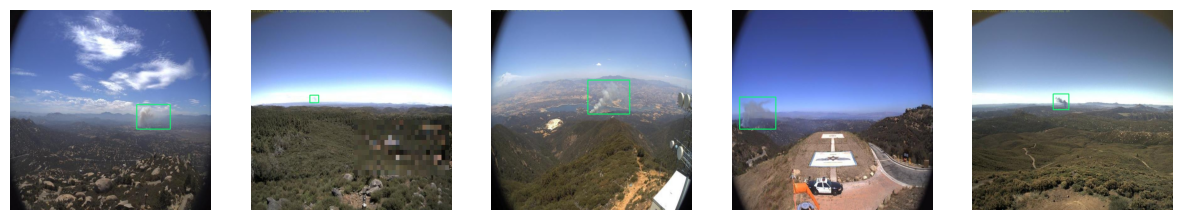

In [7]:
def print_images_in_row(path, images_list):
    plt.figure(figsize=(15, 12))
    for i, img_name in enumerate(images_list):
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path)

        # OpenCV lê a imagem como BGR
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis("off")
        # plt.title(img_name)

    plt.show()

print_images_in_row(images_with_bb_path, random_images)


Essa amostra já no mostra várias diferenças entre as imagens como em nível de brilho, escala de cores e saturação, além da possível presença por exemplo de objetos.

## Pré-processamento


Para a etapa de pré-processamento podemos realizar as seguintes operações:

- Normalização da imagem (Adequar os valores para 0 a 1)
- Aplicação de data augmentation, ou seja, criar imagens rotacionadas, espelhadas e com fumaça fora do centro.
- Transformação para escala de cinza ou outras escalas como HSV
- Redução de ruídos

Foi verificado que o algoritmo YOLOv11 já realiza o processo de normalização dos dados, colocando-os numa escala de 0 a 1 automaticamente (https://docs.ultralytics.com/pt/guides/preprocessing_annotated_data). Devido a isso iremos pular essa etapa, porém para realizá-la bastaria subtrairmos os valores de pixel dos canais de cor por 255.

Além disso como comentado na seção anterior, o dataset obtido já possui diversas imagens duplicadas e rotacionadas horizontalmente, como estamos lidando com imagens de torres e elas partem do princípio de imagens com a linha do horizonte bem definida, inicialmente talvez não fizesse sentido termos imagens rotacionadas 90º por exemplo. Ou seja, o dataset baixado já teve etapas de data augmentation realizadas.

As imagens do dataset apresentam uma grande variabilidade de brilho, constrastes e cores, vamos aplicar uma equalização no plano HSV, com isso conseguimos alterar apenas a banda Value, mantendo a característica de cores muito importante para a classificação das fumaças com o elementos do fundo. 

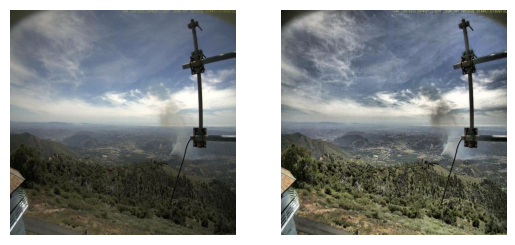

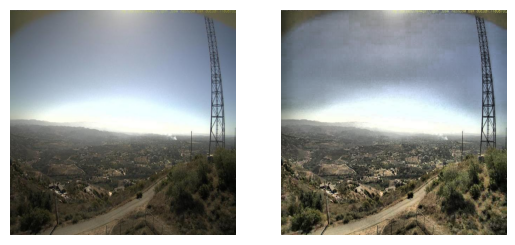

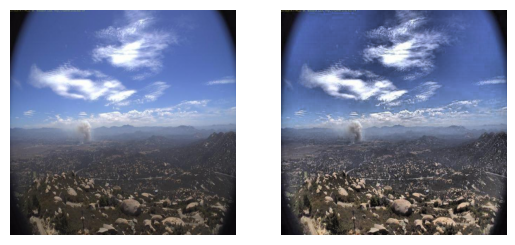

In [28]:
def equalize_brightness_hsv(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)    

    h, s, v = cv2.split(hsv)

    # CLAHE significa "Contrast Limited Adaptive Histogram Equalization"
    # Processa o contraste das imagens realizando uma equalização
    # Deixa áreas escuras mais claras e áreas muito claras mais escuras
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    # Aplicamos a equalização apenas no canal Value mantendo a cor e a saturação
    v_eq = clahe.apply(v) 

    hsv_eq = cv2.merge((h, s, v_eq))
    img = cv2.cvtColor(hsv_eq, cv2.COLOR_HSV2RGB) 

    return  img


example_images = [
    "ck0l9dfokcv7o07013t4kgamc_jpeg_jpg.rf.9c22946250a37ecfe213aba471bdb11a.jpg",
    "ck0kd8vmh68nl083835g4ngoc_jpeg_jpg.rf.3d8eea8828718e2e598d9f0e51092497.jpg",
    "ck0lwgsmatsrm0848br00vfki_jpeg_jpg.rf.02a4da7dc56668267c63121528f8c8c5.jpg"
]

for image in example_images:
    teste = os.path.join(dataset_path, path_file["train"], image)
    image = cv2.imread(teste)

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    normalized = equalize_brightness_hsv(image) # Aplica brilho

    plt.subplot(1, 2, 2)
    plt.imshow(normalized)
    plt.axis("off")
    plt.show()

As imagens anteriores foram escolhidas a título de exemplificação, podemos perceber um maior destaque dos casos de fumaça, e uma melhor visualização das imagens no geral.



Seria possível visualizar alguns artigos científicos que realizam procedimentos em imagens para melhor escolher técnicas que se adequam ao nosso caso, temos algos um exemplo de referências:

https://www.sciencedirect.com/science/article/abs/pii/S1290072902013972 \
https://www.mdpi.com/2073-8994/12/7/1075 \
https://www.mdpi.com/1999-4907/15/5/839 

Vamos realizar esse procedimento em todas as imagens do dataset para treino e validação.

In [39]:
train_processed = os.path.join(processed_dataset_path, path_file["train"])

os.makedirs(train_processed, exist_ok=True)
for image in image_files:
    train_image = os.path.join(dataset_path, path_file["train"], image)
    image_object = cv2.imread(train_image)
    normalized = equalize_brightness_hsv(cv2.cvtColor(image_object, cv2.COLOR_BGR2RGB))

    cv2.imwrite(os.path.join(train_processed, image), normalized)

In [43]:
val_processed = os.path.join(processed_dataset_path, path_file["val"])
val_image_files = [f for f in os.listdir(os.path.join(dataset_path, path_file["val"])) if f.endswith(('.jpg'))]


os.makedirs(val_processed, exist_ok=True)
for image in val_image_files:
    val_image = os.path.join(dataset_path, path_file["val"], image)
    image_object = cv2.imread(val_image)
    normalized = equalize_brightness_hsv(cv2.cvtColor(image_object, cv2.COLOR_BGR2RGB))

    cv2.imwrite(os.path.join(val_processed, image), normalized)

## Treinamento do Modelo

Nesta etapa iremos inserir nossas imagens de treino ao modelo YOLOv11 para realizar o Fine-tuning do mesmo a nossa tarefa de detecção de fumaça.

Como foi utilizado o Google Colab, o treinamento foi realizado em 15 épocas. Com um batch de 100, o que consumia aproximadamente 14 GB de GPU

In [44]:
model = YOLO("yolo11n.pt") # pt para modelo pré-treinado

# Treina o modelo no conjunto train da pasta data
# imgsz já tem como valor padrão 640
model.train(
    data=os.path.abspath(processed_data_file_path),
    epochs=15,
    batch=100,
    device=0, # 0 para GPU, -1 para CPU
    seed=42
)

print("Treinamento finalizado.")

100%|██████████| 5.35M/5.35M [00:00<00:00, 9.79MB/s]


NameError: name 'processed_data_file_path' is not defined

Vamos salvar o resultado do melhor modelo `best.pt` na pasta `artifacts/model`. Isso será feito para podermos utilizar esse objeto posteriormente para a predição. Esse passo deve ser rodado antes do eval, uma vez que este irá criar uma nova pasta com os resultados de avaliação.

In [ ]:
# Resgata o resultado do último treinamento
latest_folder = get_latest_folder(Path("runs/detect"))

best_model = os.path.join(latest_folder, "weights/best.pt")

print(best_model)
destination = "artifacts/model/best.pt"
if os.path.exists(best_model):
    shutil.move(best_model, destination)
    print("Arquivo de melhor modelo movido com sucesso.")
else:
    print("O arquivo não foi encontrado.")

runs/detect/train2/weights/best.pt
Arquivo de melhor modelo movido com sucesso.


## Avaliação do modelo

A chamada para o método `model.val()` retorna a avaliação do modelo nas imagens presentes na pasta `valid` do dataset, ou seja, nosso conjunto de teste, com isso podemos acessar imagens contendo gráficos de métricas para análise posterior.

In [19]:
# Avalia no conjunto de validação (valid)
metrics = model.val()

Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /content/desafio-data-science-2025/datasets/data/valid/labels.cache... 147 images, 0 backgrounds, 0 corrupt: 100%|██████████| 147/147 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.58s/it]


                   all        147        147      0.838       0.85      0.904      0.534
Speed: 6.2ms preprocess, 4.5ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/train22



O modelo YOLO possui como resultado as seguintes métricas para a deteção de "objetos" em imagens:

In [20]:
metrics.results_dict

{'metrics/precision(B)': 0.8383723636946852,
 'metrics/recall(B)': 0.8503401360544217,
 'metrics/mAP50(B)': 0.9038915860524149,
 'metrics/mAP50-95(B)': 0.5341664420036911,
 'fitness': 0.5711389564085635}

A partir da [documentação de métricas](https://docs.ultralytics.com/guides/yolo-performance-metrics/#choosing-the-right-metrics) referente ao YOLO, temos a seguinte explicação para as métricas de classe mostradas anteriormente:

- Precision: A acurácia de quantas detecções foram corretas.
- Recall A habilidade do modelo em detectar todas as instâncias do objeto em imagens, nesse caso fumaça.
- mAP50: Mede a precisão média das detecções do modelo considerando um limiar de IoU (Intersection over Union, ou seja o bounding box predito com o verdadeiro) de 50%.
- mAP50-95: Semelhante a métrica anterior porém fornecendo um limiar variável, avaliando o modelo em detecções mais difíceis, importante para casos em que a precisão é essencial.
- A métrica fitness é uma métrica composta para medir o desempenho do modelo de forma geral.

A seguir temos as métricas de velocidade:

In [21]:
metrics.speed

{'preprocess': 6.190585578231233,
 'inference': 4.5451745510209065,
 'loss': 0.00015059863920393834,
 'postprocess': 2.260242850340336}

Temos como métrica de tempo principal o valor de ms necessário para a ação de inferência de uma única imagem.

Podemos visualizar também os gráficos de métrica gerados pelo método val.


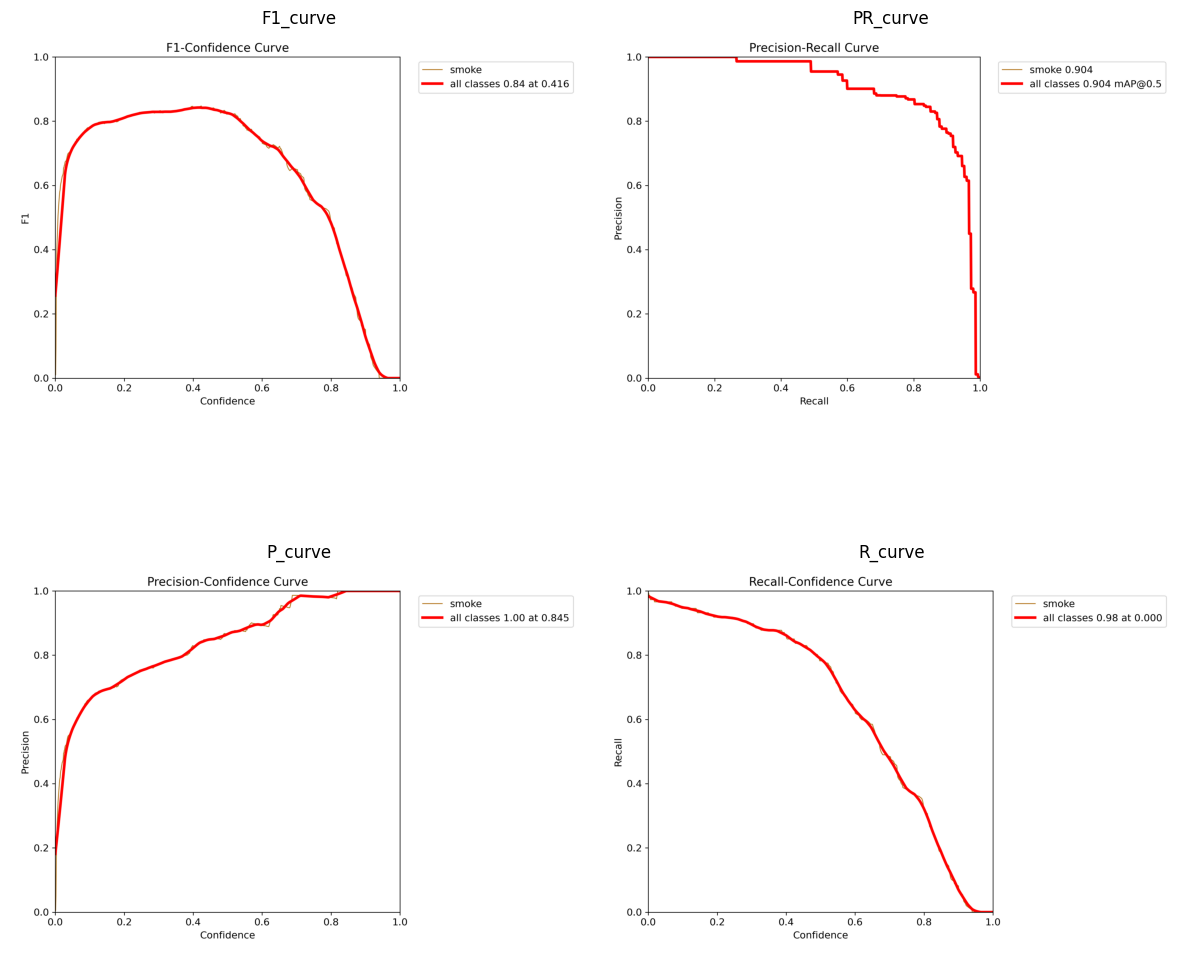

In [23]:
latest_folder = get_latest_folder(Path("runs/detect"))

graphs = [
    "F1_curve",
    "PR_curve",
    "P_curve",
    "R_curve"
]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for i, graph_name in enumerate(graphs):
    img_path = Path(os.path.join(latest_folder, f"{graph_name}.png"))
    if img_path.exists():
        img = cv2.imread(img_path)

        ax = axes[i // 2, i % 2]
        ax.imshow(img)
        ax.set_title(graph_name)
        ax.axis("off")

plt.tight_layout()
plt.show()


Temos:
- A curva F1, em que o F1-Score se trata da média harmónica da precisão e da revocação (recall), para a curva temos este valor para diferentes limiares de confiança, visualizamos que na medida que a confiança aumenta a métrica de F1 tende a abaixar. Em um limiar médio de 0.5 temos um F1 Score acima de 0.8.
- A curva de Precision e Recall, no geral essa curva é importante para lidar com problema de desbalanceamento quando há a existência de múltiplas classes, podemos a partir dela analisa o trade off entre as duas métricas.
- Curva de Precisão e Confiança, semelhante a primeira curva porém apenas para precisão.
- Curva de Recall e Confiança, semelhante a primeira curva porém apenas para revocação.

Podemos verificar também as matrizes de confusão geradas, como só temos apenas uma classe, a matriz de confusão possui apenas os valores de fumaça e background (classe gerada automaticamente).   

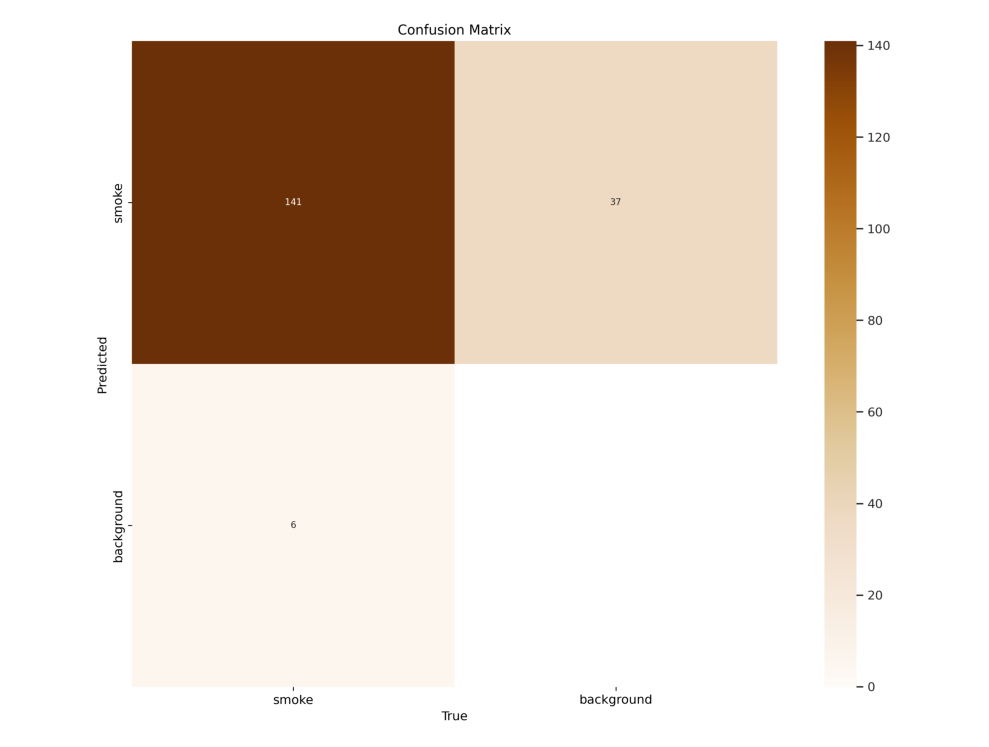

In [24]:
plt.figure(figsize=(10, 10))
img_path = Path(os.path.join(latest_folder, "confusion_matrix.png"))
if img_path.exists():
    img = cv2.imread(img_path)

    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()


Temos a predominância de falsos positivos do que falsos negativos, considerando o o caso de fogo em floresta queremos reduzir ao máximo os casos de falsos negativos, uma vez que deixar a incidência do fogo se alastrar é o pior cenário, enquanto o falso positivo pode ser verificado e validado por um agente humano antes de ser tomada qualquer ação.

## Predição em imagens de teste

In [25]:
test_image_files = [f for f in os.listdir(os.path.join(dataset_path, path_file["test"])) if f.endswith(('.jpg'))]
random_test_images = random.sample(test_image_files, 5)
random_test_images

['ck0khrg9xan7u0721mn5rxpzo_jpeg_jpg.rf.030755fa9e22c118cbe345919d196619.jpg',
 'ck0nepj3s015b0a88py3wvbqu_jpeg_jpg.rf.de3b938218e0a09a065def9a4ad2950b.jpg',
 'ck0kosu846k350794gya7bot0_jpeg_jpg.rf.4d1e5515c244ea76b84bf2b45334e9c8.jpg',
 'ck0m1n0c1hbus0863ti6kd58t_jpeg_jpg.rf.eb93fb80590669f5f0156aebed417cbc.jpg',
 'ck0nftcfgka7e0848a9ie2b3b_jpeg_jpg.rf.792243de554062c1def618b87c5bad5d.jpg']

Vamos realizar a inferência em múltiplas imagens de teste.

In [32]:
results = {}
for image in random_test_images:
    test_image = os.path.join(
        dataset_path,
        path_file["test"],
        image
    )

    results[test_image] =  model(test_image)

print(results)


image 1/1 /content/desafio-data-science-2025/datasets/data/test/images/ck0khrg9xan7u0721mn5rxpzo_jpeg_jpg.rf.030755fa9e22c118cbe345919d196619.jpg: 640x640 1 smoke, 12.3ms
Speed: 2.3ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/desafio-data-science-2025/datasets/data/test/images/ck0nepj3s015b0a88py3wvbqu_jpeg_jpg.rf.de3b938218e0a09a065def9a4ad2950b.jpg: 640x640 1 smoke, 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/desafio-data-science-2025/datasets/data/test/images/ck0kosu846k350794gya7bot0_jpeg_jpg.rf.4d1e5515c244ea76b84bf2b45334e9c8.jpg: 640x640 2 smokes, 9.0ms
Speed: 1.7ms preprocess, 9.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/desafio-data-science-2025/datasets/data/test/images/ck0m1n0c1hbus0863ti6kd58t_jpeg_jpg.rf.eb93fb80590669f5f0156aebed417cbc.jpg: 640x640 1 smoke, 8.2ms
Speed: 1.7ms preprocess

Com os resultados já obtidos agora necessitamos amostrá-las graficamente.

datasets/data/test/images/ck0khrg9xan7u0721mn5rxpzo_jpeg_jpg.rf.030755fa9e22c118cbe345919d196619.jpg
datasets/data/test/images/ck0nepj3s015b0a88py3wvbqu_jpeg_jpg.rf.de3b938218e0a09a065def9a4ad2950b.jpg
datasets/data/test/images/ck0kosu846k350794gya7bot0_jpeg_jpg.rf.4d1e5515c244ea76b84bf2b45334e9c8.jpg
datasets/data/test/images/ck0m1n0c1hbus0863ti6kd58t_jpeg_jpg.rf.eb93fb80590669f5f0156aebed417cbc.jpg
datasets/data/test/images/ck0nftcfgka7e0848a9ie2b3b_jpeg_jpg.rf.792243de554062c1def618b87c5bad5d.jpg


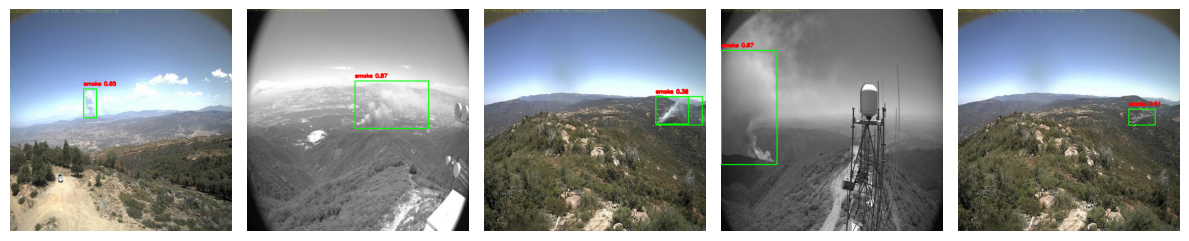

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(12, 12))

for i, (image_path, image_results) in enumerate(results.items()):
  print(image_path)
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  for result in image_results:
    boxes = result.boxes
    for box in boxes:
      x1, y1, x2, y2 = map(int, box.xyxy[0])

      # Score de confiança
      conf = float(box.conf[0])

      # Classe de fumaça (smoke)
      cls = int(box.cls[0])
      label = f"{model.names[cls]} {conf:.2f}"

      # Preenche o Bounding Box e o valor de Confiança
      img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
      img = cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, (255, 0, 0), 2, cv2.LINE_AA)

  ax = axes[i]
  ax.imshow(img)
  # ax.set_title(f"Imagem {i+1}")
  ax.axis("off")

plt.tight_layout()
plt.show()


O próximo passo é essencial em Google Colab para baixar novamente o projeto executado.

In [37]:
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"
# !zip -r /content/project.zip /content/

# from google.colab import files
# files.download('/content/project.zip')

A saída de streaming foi truncada nas últimas 5000 linhas.
  adding: content/desafio-data-science-2025/datasets/data/train/images/ck0nfrec983h90701yvzbsczw_jpeg_jpg.rf.4640b92ea4bc613b967e7b9a9abc2bbe.jpg (deflated 2%)
  adding: content/desafio-data-science-2025/datasets/data/train/images/ck0kkv2jf8pil09448qnz1ndu_jpeg_jpg.rf.3ef6e8b98204687a0fc6864764c6099b.jpg (deflated 4%)
  adding: content/desafio-data-science-2025/datasets/data/train/images/ck0qd6v51ib0j0701sf2wolfq_jpeg_jpg.rf.d75f1f96935d0073fec4b0745983301b.jpg (deflated 1%)
  adding: content/desafio-data-science-2025/datasets/data/train/images/ck0u0i88bunv00944unevdbqg_jpeg_jpg.rf.78af7862c52d1abe137de8103da5ee99.jpg (deflated 3%)
  adding: content/desafio-data-science-2025/datasets/data/train/images/ck0kmh9hhkg5e0a46we9ywaxl_jpeg_jpg.rf.5f963cba97837863db5fc31786490b83.jpg (deflated 2%)
  adding: content/desafio-data-science-2025/datasets/data/train/images/ck0neh5qnjfoh0848s35xyyj8_jpeg_jpg.rf.92a835e63feca310211add438fd4cc9b

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>